# Bandit tester

## Preliminaries

In [1]:
from abc import ABC, abstractmethod
from collections import defaultdict, Counter
import json
import matplotlib.pyplot as plt
from multipledispatch import dispatch
import numpy as np
import os
from scipy.stats import t as student_t
from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import bernoulli
import scipy
from typing import Type, TypeVar
from tqdm import tqdm
import time

## Starter pack: distributions, basic strategy, bandit tester and comparing function

In [2]:
class Distribution(ABC):
    def __init__(self, num_distrib, loc_sampler):
        self.num_distrib = num_distrib
        self.loc_sampler = loc_sampler
        self.locations = self.loc_sampler(size=num_distrib)
        self.distributions: list[scipy.stats.rv_continuous] = self._create_distributions()

    @abstractmethod
    def _create_distributions(self) -> list[scipy.stats.rv_continuous]:
        pass

    def pull_the_lever(self, pos):
        return self.distributions[pos].rvs()  # Draw a sample from the specified distribution
    

class Gaussian(Distribution):
    def __init__(self, num_distrib, sigma=1, loc_sampler=norm.rvs):
        self.sigma = sigma  # deviation for gaussian distribution
        super().__init__(num_distrib, loc_sampler=loc_sampler)

    def _create_distributions(self):
        return [
            norm(loc=loc, scale=self.sigma) for loc in self.locations
        ]


class Student(Distribution):
    def __init__(self, num_distrib, mu, loc_sampler=norm.rvs, need_scale=True):
        self.need_scale = need_scale
        self.mu = mu  # degrees of freedom for Student's t distribution
        super().__init__(num_distrib, loc_sampler=loc_sampler)

    def _create_distributions(self):
        if self.need_scale and self.mu > 2:
            scale = np.sqrt((self.mu - 2) / self.mu)
            return [
                student_t(df=self.mu, loc=loc, scale=scale) for loc in self.locations
            ]
        else:
            return [
                student_t(df=self.mu, loc=loc) for loc in self.locations
            ]


class Cauchy(Distribution):
    def __init__(self, num_distrib, gamma, loc_sampler=norm.rvs):
        self.gamma = gamma  # scale parameter for Cauchy distribution
        super().__init__(num_distrib, loc_sampler=loc_sampler)   

    def _create_distributions(self):
        return [
            cauchy(loc=loc, scale=self.gamma) for loc in self.locations
        ]


In [3]:
class Strategy(ABC):
    def __init__(self, num_arms, step_size):
        self.num_arms = num_arms
        self.q_values = np.zeros(num_arms) # Initialize Q-values
        self.counts = np.zeros(num_arms)  # Track visits per arm
        self.step_size = step_size

    @abstractmethod
    def choose_arm(self) -> tuple[int, np.ndarray]:
        pass

    @abstractmethod
    def update(self, arm, reward):
        pass

In [4]:
class BanditTester:
    def __init__(self, distribution: Type[Distribution], strategy: Type[Strategy], distribution_params: dict, strategy_params: dict, num_arms=10, test_num=2000, test_len=1000):
        np.random.seed(42)
        self.distribution = distribution
        self.strategy = strategy
        self.distribution_params = dict(distribution_params)
        self.distribution_params["num_distrib"] = num_arms
        self.strategy_params = dict(strategy_params)
        self.strategy_params["num_arms"] = num_arms
        self.test_num = test_num
        self.test_len = test_len

        self.average_rewards = np.zeros(self.test_len)
        self.optimal_actions = np.zeros(self.test_len)

        self.metric_results = {}
        self.metric_results['average_rewards'] = np.zeros(self.test_len)
        self.metric_results['optimal_actions'] = np.zeros(self.test_len)

    def _make_one_step(self, strategy: Strategy, distribution: Distribution) -> tuple[int, float, np.ndarray]:
        arm, probs = strategy.choose_arm()
        reward = distribution.pull_the_lever(arm)
        strategy.update(arm, reward)

        return arm, reward, probs
    
    def _get_max_reward(self, distribution: Distribution):
        return np.max(distribution.locations)
    
    def _test_one_test(self, strategy: Strategy, distribution: Distribution):
        optimal_arm = np.argmax(distribution.locations)  # Determine the optimal arm

        for i in range(self.test_len):
            arm, reward, _ = self._make_one_step(strategy, distribution)

            self.metric_results['average_rewards'][i] += reward / self.test_num
            self.metric_results['optimal_actions'][i] += int(arm == optimal_arm) / self.test_num

    def test(self) -> dict[str, np.ndarray]:
        for _ in tqdm(range(self.test_num)):
            strategy = self.strategy(**self.strategy_params)  # Create a new strategy instance for each run
            distribution = self.distribution(**self.distribution_params)  # Create a new distribution instance for each run

            self._test_one_test(strategy, distribution)

        return self.metric_results


In [5]:
avg_reward_metric = "Average aversion reward"
real_avg_reward_metric = "Real average aversion reward"
opt_action_metric = "% Optimal Action Metric"
avg_regret_metric = "Average aversion regret"
real_avg_regret_metric = "Real average aversion regret"

InheritorsOfDistr = TypeVar('InheritorsOfDistr', bound=Distribution)
InheritorsOfStrategy = TypeVar('InheritorsOfStrategy', bound=Strategy)

In [171]:
def compare_strategies(distributions: list[type[InheritorsOfDistr]],
                       distributions_params: list[dict],
                       distributions_names: list[str],
                       strategies: list[type[InheritorsOfStrategy]],
                       strategies_params: list[dict]):

    final_metrics = {}

    for distribution, distribution_params, distribution_name in zip(distributions, distributions_params, distributions_names):
        print(distribution_name)
        final_metrics[distribution_name] = defaultdict(list)

        for strategy, strategy_params in zip(strategies, strategies_params):
            bandit_tester = BanditTester(distribution, strategy, distribution_params, strategy_params)
            metrics = bandit_tester.test()

            for key, value in metrics.items():
                final_metrics[distribution_name][key].append(value.tolist())

    return final_metrics
        

In [6]:
metrics_titles = [avg_reward_metric, opt_action_metric]
metrics_names = ['average_rewards', 'optimal_actions']
plots_cnt = 2

In [7]:
def plot_strategies_results(metrics, labels, set_ylim=lambda key, i, axes_flat: None, set_legend_outside=False):

    # Define x-axis (steps)
    steps = list(range(1, 1001))

    # Create the figure and individual subplots (4 rows, 2 columns)
    fig, axes = plt.subplots(len(metrics), plots_cnt, figsize=(16, 4 * len(metrics)))

    # Flatten the 2D array of subplots to iterate over them efficiently
    axes_flat = axes.flatten()

    # Common titles for each plot
    fig.suptitle("Performance of Strategies", fontsize=18)
    for ax in axes_flat:
        ax.set_xlabel("Steps", size=12)

    # Loop through each key (distribution)
    for i, key in enumerate(metrics.keys()):
        for k, metric_name in enumerate(metrics_names):
            for label, data in zip(labels, metrics[key][metric_name]):
                axes_flat[plots_cnt * i + k].plot(steps,
                                          data if metric_name != 'optimal_actions' else [100 * x for x in data],
                                          label=label)
                
        for k, metric_title in enumerate(metrics_titles):
            axes_flat[plots_cnt * i + k].set_title(f"{key} - {metric_title}", size=12)
            axes_flat[plots_cnt * i + k].set_ylabel(metric_title, size=12)
            if set_legend_outside is False:
                axes_flat[plots_cnt * i + k].legend()

        set_ylim(key, i, axes_flat)

    if set_legend_outside is True:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.1), loc='lower center', ncol=len(labels) // 1, prop={'size': 20})
        

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()



In [8]:
def plot_distributions_results(metrics, labels, set_ylim=lambda label, i, axes_flat: None):

    # Define x-axis (steps)
    steps = list(range(1, 1001))

    # Create the figure and individual subplots (4 rows, 3 columns)
    fig, axes = plt.subplots(len(labels), plots_cnt, figsize=(16, 4 * len(labels)))

    # Flatten the 2D array of subplots to iterate over them efficiently
    axes_flat = axes.flatten()

    # Common titles for each plot
    fig.suptitle("Performance of Strategies", fontsize=16)
    for ax in axes_flat:
        ax.set_xlabel("Steps")

    for i, label in enumerate(labels):
        for key in metrics.keys():
            for k, metric_name in enumerate(metrics_names):
                if key != "Standard Cauchy":
                    axes_flat[plots_cnt * i + k].plot(steps,
                                            metrics[key][metric_name][i] if metric_name != 'optimal_actions'
                                            else [100 * x for x in metrics[key][metric_name][i]],
                                            label=key)

        for k, metric_title in enumerate(metrics_titles):
            axes_flat[plots_cnt * i + k].set_title(f"{label} - {metric_title}")
            axes_flat[plots_cnt * i + k].set_ylabel(metric_title)
            axes_flat[plots_cnt * i + k].legend()
            
        set_ylim(label, i, axes_flat)
        

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

In [9]:
def apply_running_window(metrics, window=5, distr_to_average="Student with "+r"$\nu=2$", metric_to_average='average_rewards'):
    for i, step_vals in enumerate(metrics[distr_to_average][metric_to_average]):
        average_step_vals = []
        for ind in range(len(step_vals) - window + 1):
            average_step_vals.append(np.mean(step_vals[ind:ind+window]))
        for ind in range(window - 1):
            average_step_vals.insert(0, np.nan)
        metrics[distr_to_average][metric_to_average][i] = average_step_vals

In [10]:
all_metrics_path = "all_metrics.json"

def save_new_metrics(metrics, test_key):
    if os.path.exists(all_metrics_path):
        # read existing file and append new data
        with open(all_metrics_path,"r") as f:
            all_metrics = json.load(f)
    else:
        # create new json
        all_metrics = {}

    all_metrics[test_key] = metrics
    with open(all_metrics_path, "w") as write_file:
        json.dump(all_metrics, write_file)

## Comparing greedy and $\epsilon$-greedy strategies

In [56]:
class EpsilonGreedy(Strategy):
    def __init__(self, num_arms, epsilon=0.1, step_size=lambda count: 1 / count):
        super().__init__(num_arms, step_size=step_size)
        self.epsilon = epsilon

    def choose_arm(self):
        if np.random.random() < self.epsilon:
            # Explore: choose random arm
            return np.random.randint(0, self.num_arms), np.ones(self.num_arms) / self.num_arms
        else:
            # Exploit: choose arm with highest estimated reward
            probs = np.zeros(self.num_arms)
            probs[np.argmax(self.q_values)] = 1
            return np.argmax(self.q_values), probs

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.q_values[arm] = self.q_values[arm] + self.step_size(self.counts[arm]) * (reward - self.q_values[arm])


class Greedy(EpsilonGreedy):
    def __init__(self, num_arms, step_size=lambda count: 1 / count):
        super().__init__(num_arms, epsilon=0, step_size=step_size)


In [57]:
distributions = [Gaussian, Student, Student, Student, Cauchy]
distributions_params = [{'sigma': 1}, {'mu': 3}, {'mu': 2.1}, {'mu': 2}, {'gamma': 1}]
distributions_names = ["Standard Normal", "Student with "+r"$\nu=3$", "Student with "+r"$\nu=2.1$", "Student with "+r"$\nu=2$", "Standard Cauchy"]

In [58]:
strategies = [Greedy, EpsilonGreedy, EpsilonGreedy]
strategies_params = [{}, {'epsilon': 0.01}, {'epsilon': 0.1}]

In [59]:
metrics = compare_strategies(distributions, distributions_params, distributions_names, strategies, strategies_params)

Standard Normal


100%|██████████| 2000/2000 [02:36<00:00, 12.76it/s]


Student with $\nu=3$


100%|██████████| 2000/2000 [02:38<00:00, 12.66it/s]


Student with $\nu=2.1$


100%|██████████| 2000/2000 [02:42<00:00, 12.28it/s]


Student with $\nu=2$


100%|██████████| 2000/2000 [02:26<00:00, 13.65it/s]


Standard Cauchy


100%|██████████| 2000/2000 [02:36<00:00, 12.75it/s]


In [60]:
save_new_metrics(metrics, 'eps_greedy_test')

In [130]:
with open(all_metrics_path,"r") as f:
    all_metrics = json.load(f)

In [131]:
apply_running_window(all_metrics['eps_greedy_test'])

In [62]:
labels = [r"$\epsilon = 0$ (greedy)", r"$\epsilon = 0.01$", r"$\epsilon = 0.1$"]

def set_ylim(key: str, i: int, axes_flat) -> None:
    axes_flat[plots_cnt * i].set_ylim(0.4, None)  # Set lowest y-axis value to 0.4
    axes_flat[plots_cnt * i + 1].set_ylim(15, 90)  # Set y-axis limits for optimal action to [15, 90]

    # Special adjustments for the last row (Standard Cauchy)
    if key == "Standard Cauchy":
        axes_flat[plots_cnt * i].set_ylim(-25, 25)  # Set x-axis limits for average reward
        axes_flat[plots_cnt * i + 1].set_ylim(15, 40)  # Set x-axis limits for optimal action

def set_label_ylim(label: str, i: int, axes_flat) -> None:
    axes_flat[plots_cnt * i].set_ylim(0.6, 1.6)

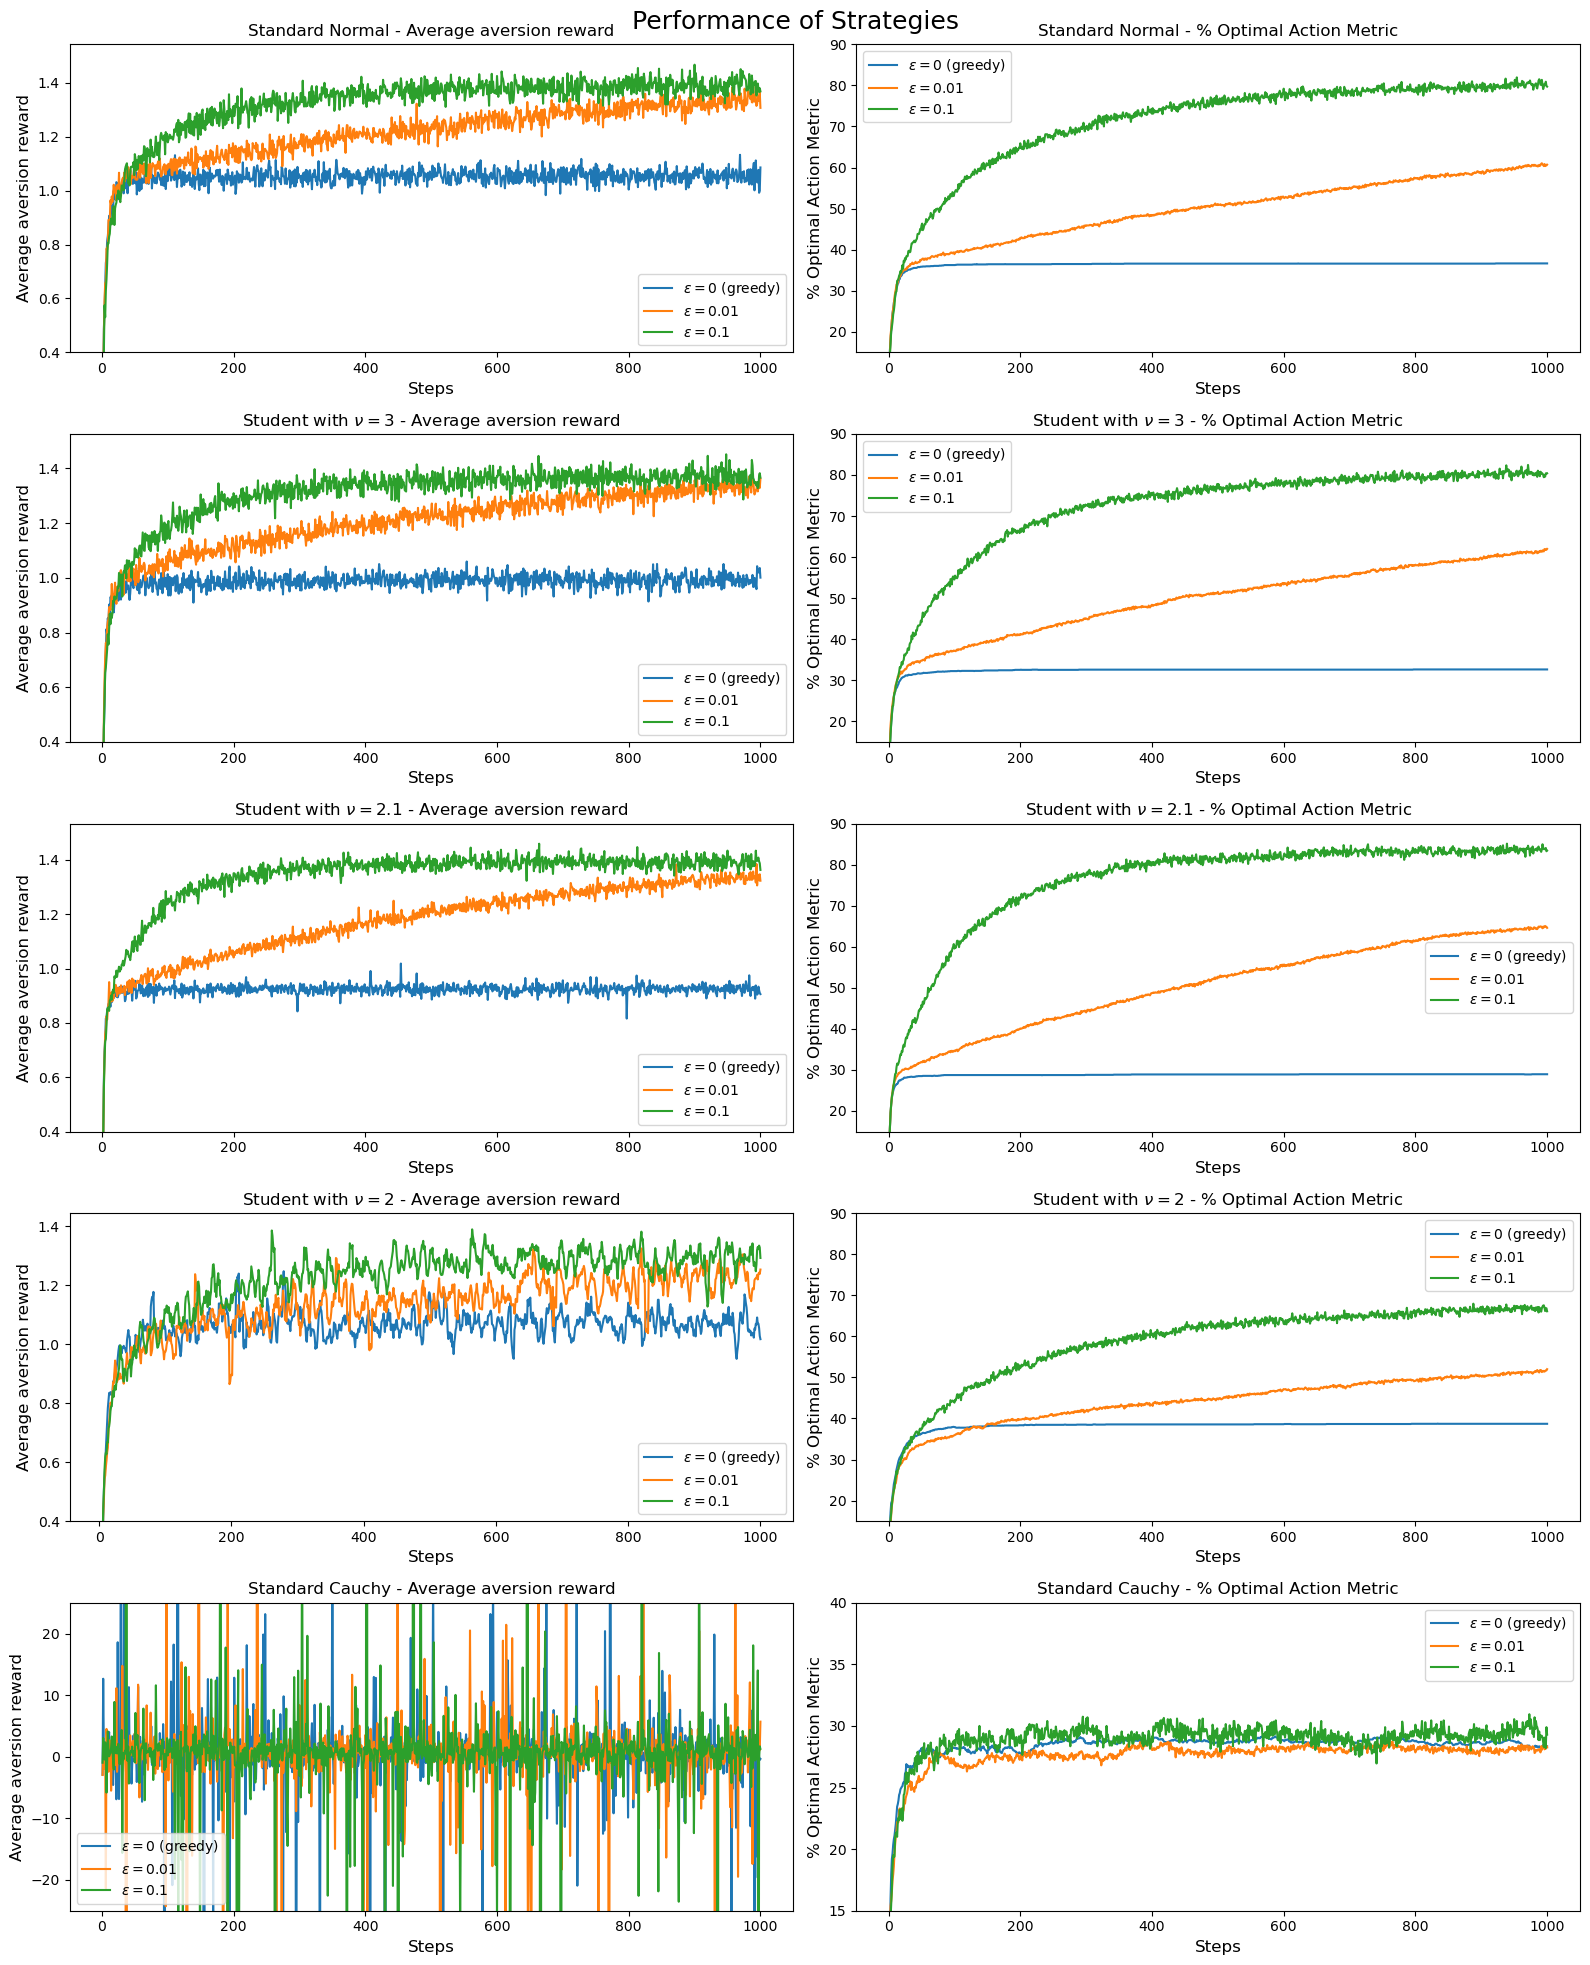

In [132]:
plot_strategies_results(all_metrics['eps_greedy_test'], labels, set_ylim)

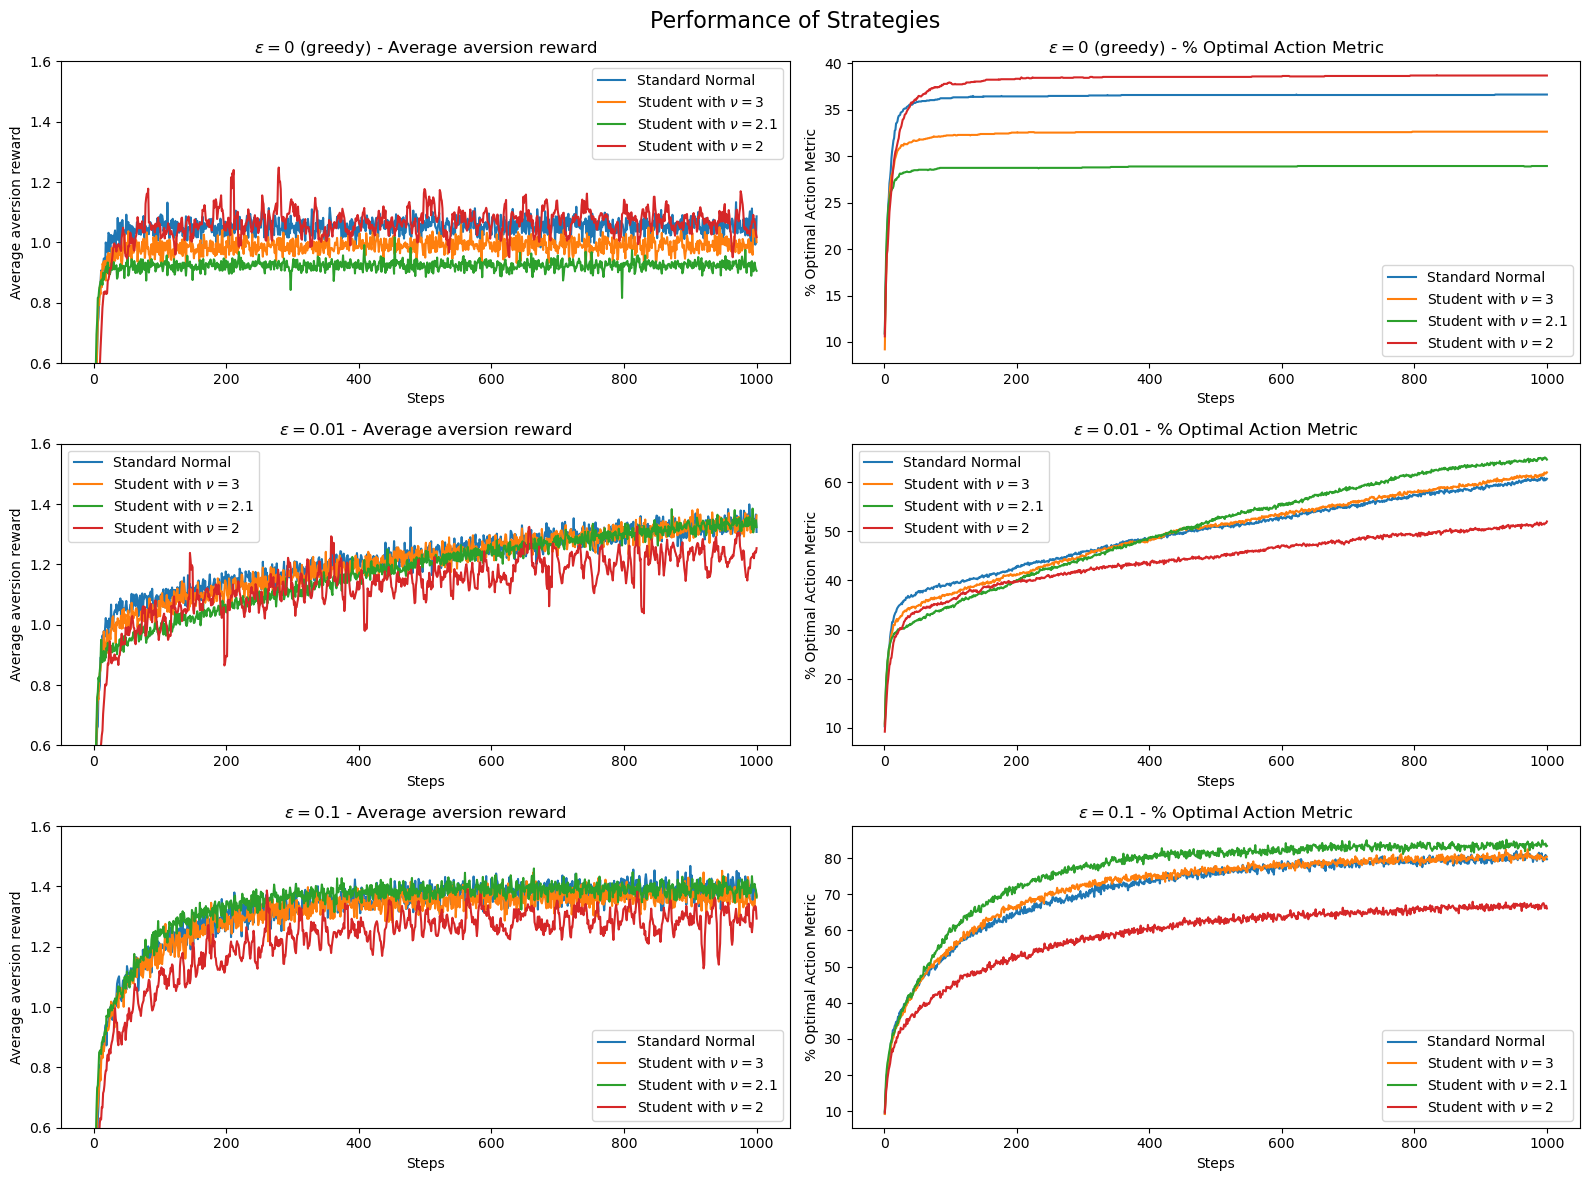

In [133]:
plot_distributions_results(all_metrics['eps_greedy_test'], labels, set_ylim=set_label_ylim)

## Positive initialization

In [134]:
class PositiveQ(EpsilonGreedy):
    def __init__(self, num_arms, epsilon=0, step_size=lambda _: 0.1, pos_q=5):
        super().__init__(num_arms, epsilon=epsilon, step_size=step_size)
        self.q_values = np.ones(num_arms) * pos_q  # Initialize Q-values with positive values


In [135]:
strategies = [PositiveQ, PositiveQ, EpsilonGreedy]
strategies_params = [{'epsilon': 0}, {'epsilon': 0.1}, {'epsilon': 0.1, 'step_size': lambda _: 0.1}]

In [137]:
metrics = compare_strategies(distributions, distributions_params, distributions_names, strategies, strategies_params)

Standard Normal


100%|██████████| 2000/2000 [02:21<00:00, 14.11it/s]


Student with $\nu=3$


100%|██████████| 2000/2000 [02:42<00:00, 12.34it/s]


Student with $\nu=2.1$


100%|██████████| 2000/2000 [02:30<00:00, 13.28it/s]


Student with $\nu=2$


100%|██████████| 2000/2000 [02:28<00:00, 13.49it/s]


Standard Cauchy


100%|██████████| 2000/2000 [02:42<00:00, 12.33it/s]


In [138]:
save_new_metrics(metrics, 'positive_init_test')

In [139]:
with open(all_metrics_path,"r") as f:
    all_metrics = json.load(f)

In [140]:
apply_running_window(all_metrics['positive_init_test'])

In [141]:
labels = ["Optimistic, greedy"+"\n"+r"$Q_1=5, \epsilon = 0$",
          r"Optimistic, $\epsilon$-greedy"+"\n"+r"$Q_1=5, \epsilon = 0.1$",
          r"Realistic, $\epsilon$-greedy"+"\n"+r"$Q_1=0, \epsilon = 0.1$"]

def set_ylim(key: str, i: int, axes_flat) -> None:
    axes_flat[2 * i].set_ylim(0.2, None)  # Set lowest y-axis value to 0.2

    # Special adjustments for the last row (Standard Cauchy)
    if key == "Standard Cauchy":
        axes_flat[2 * i].set_ylim(-25, 25)  # Set x-axis limits for average reward
        axes_flat[2 * i + 1].set_ylim(None, 35)  # Set x-axis limits for optimal action

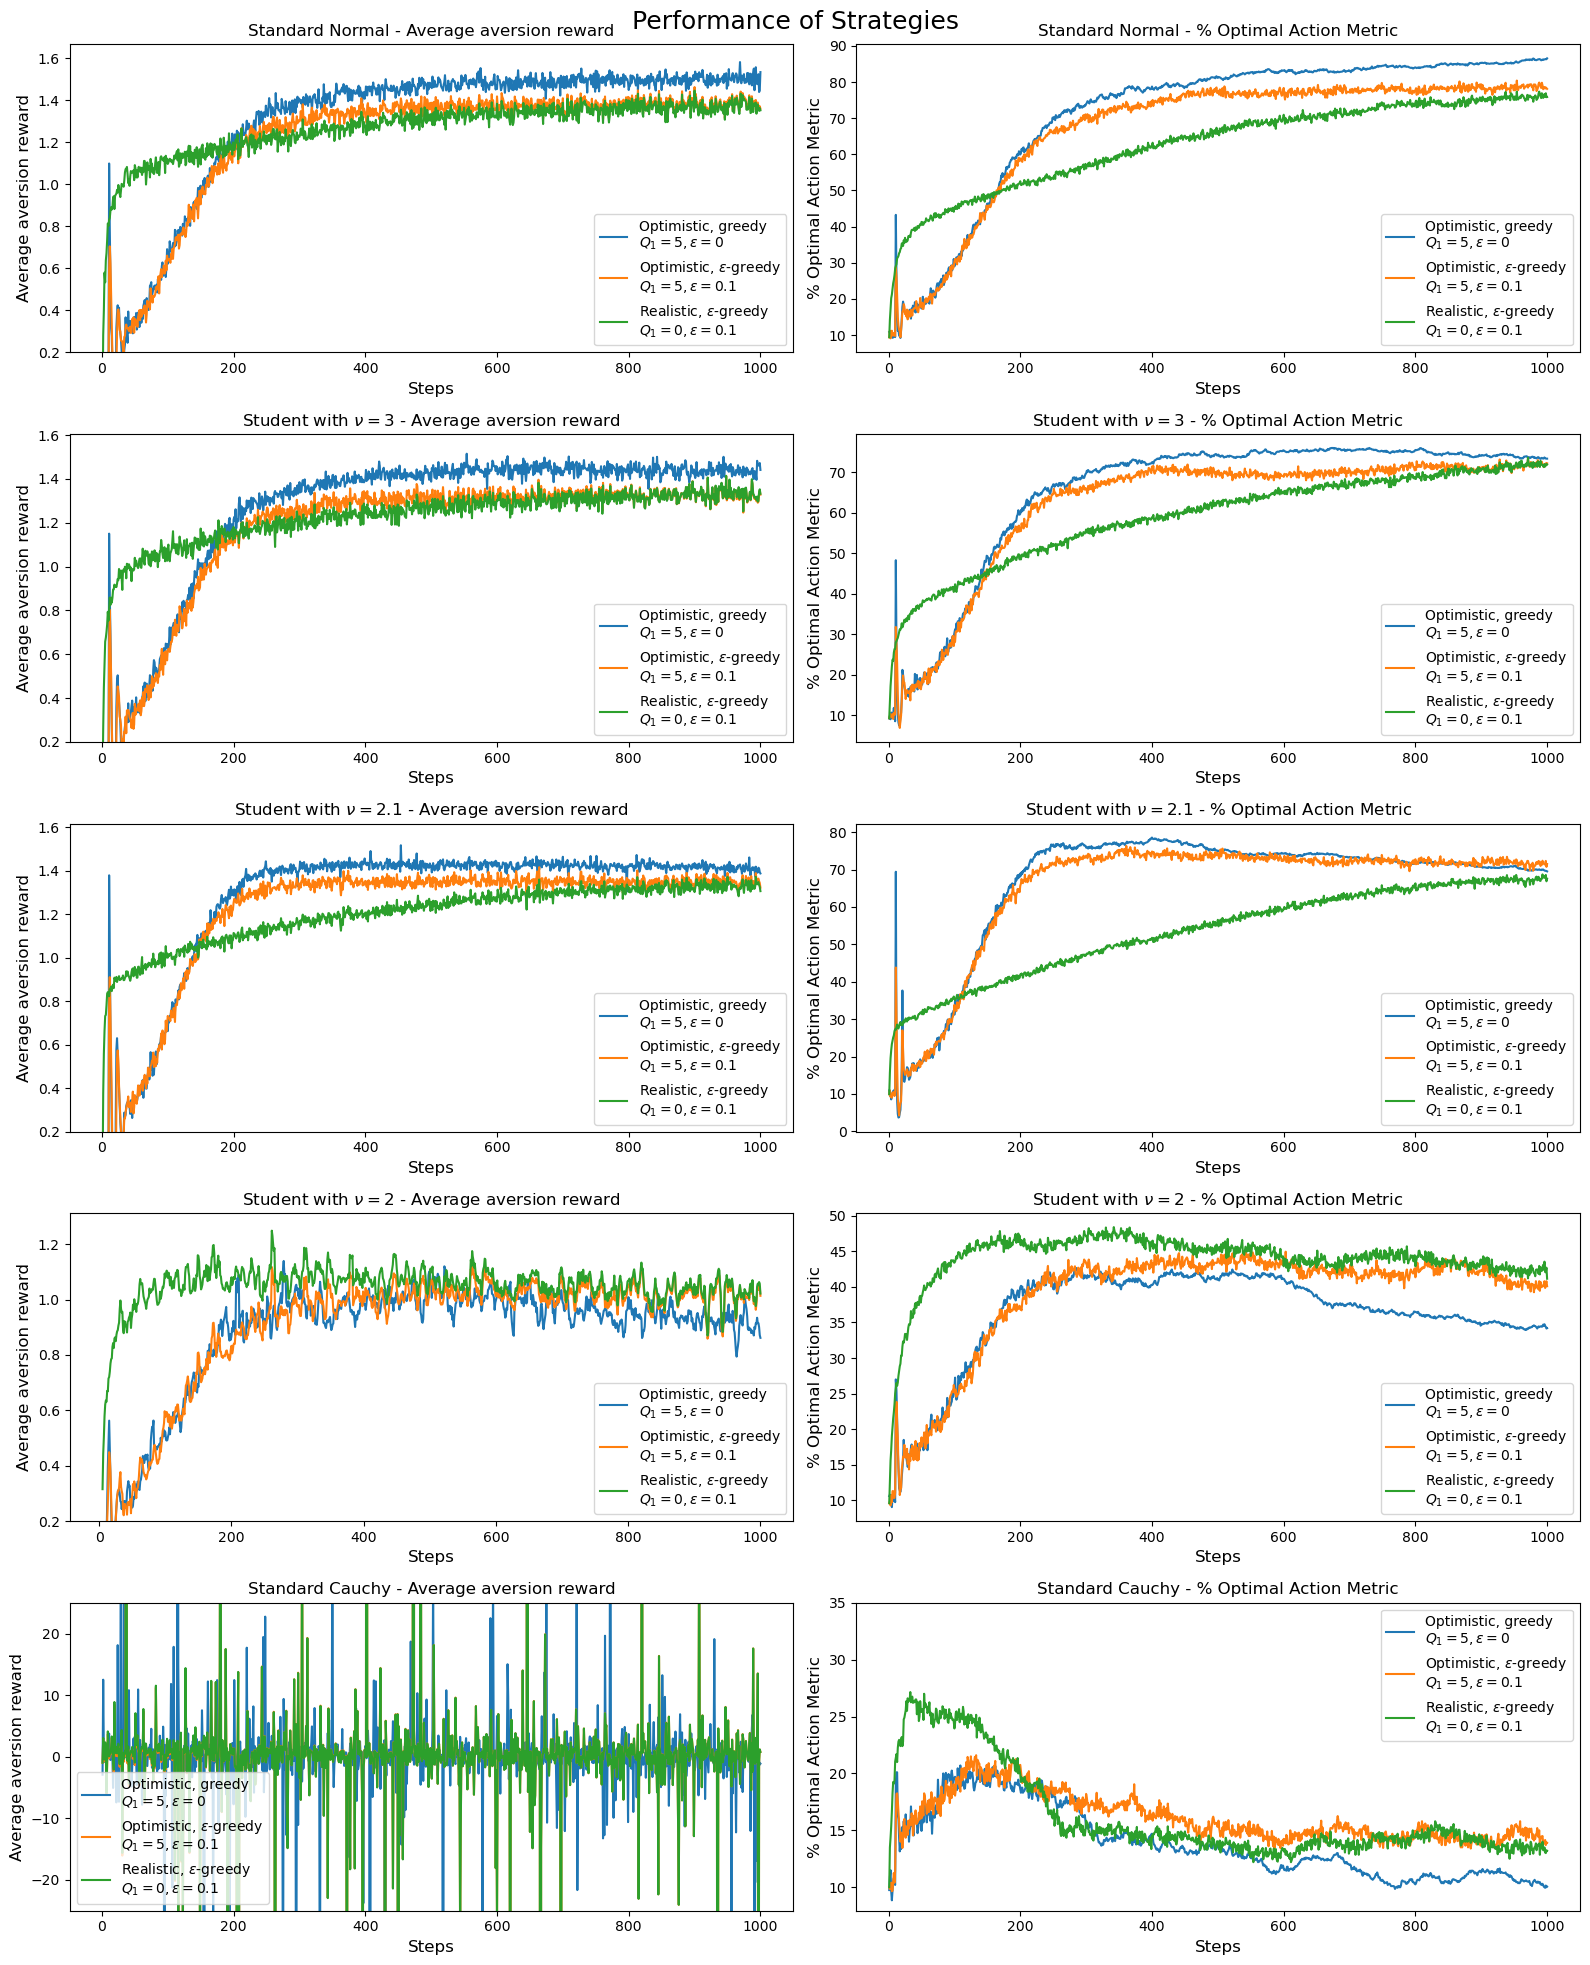

In [142]:
plot_strategies_results(all_metrics['positive_init_test'], labels, set_ylim)

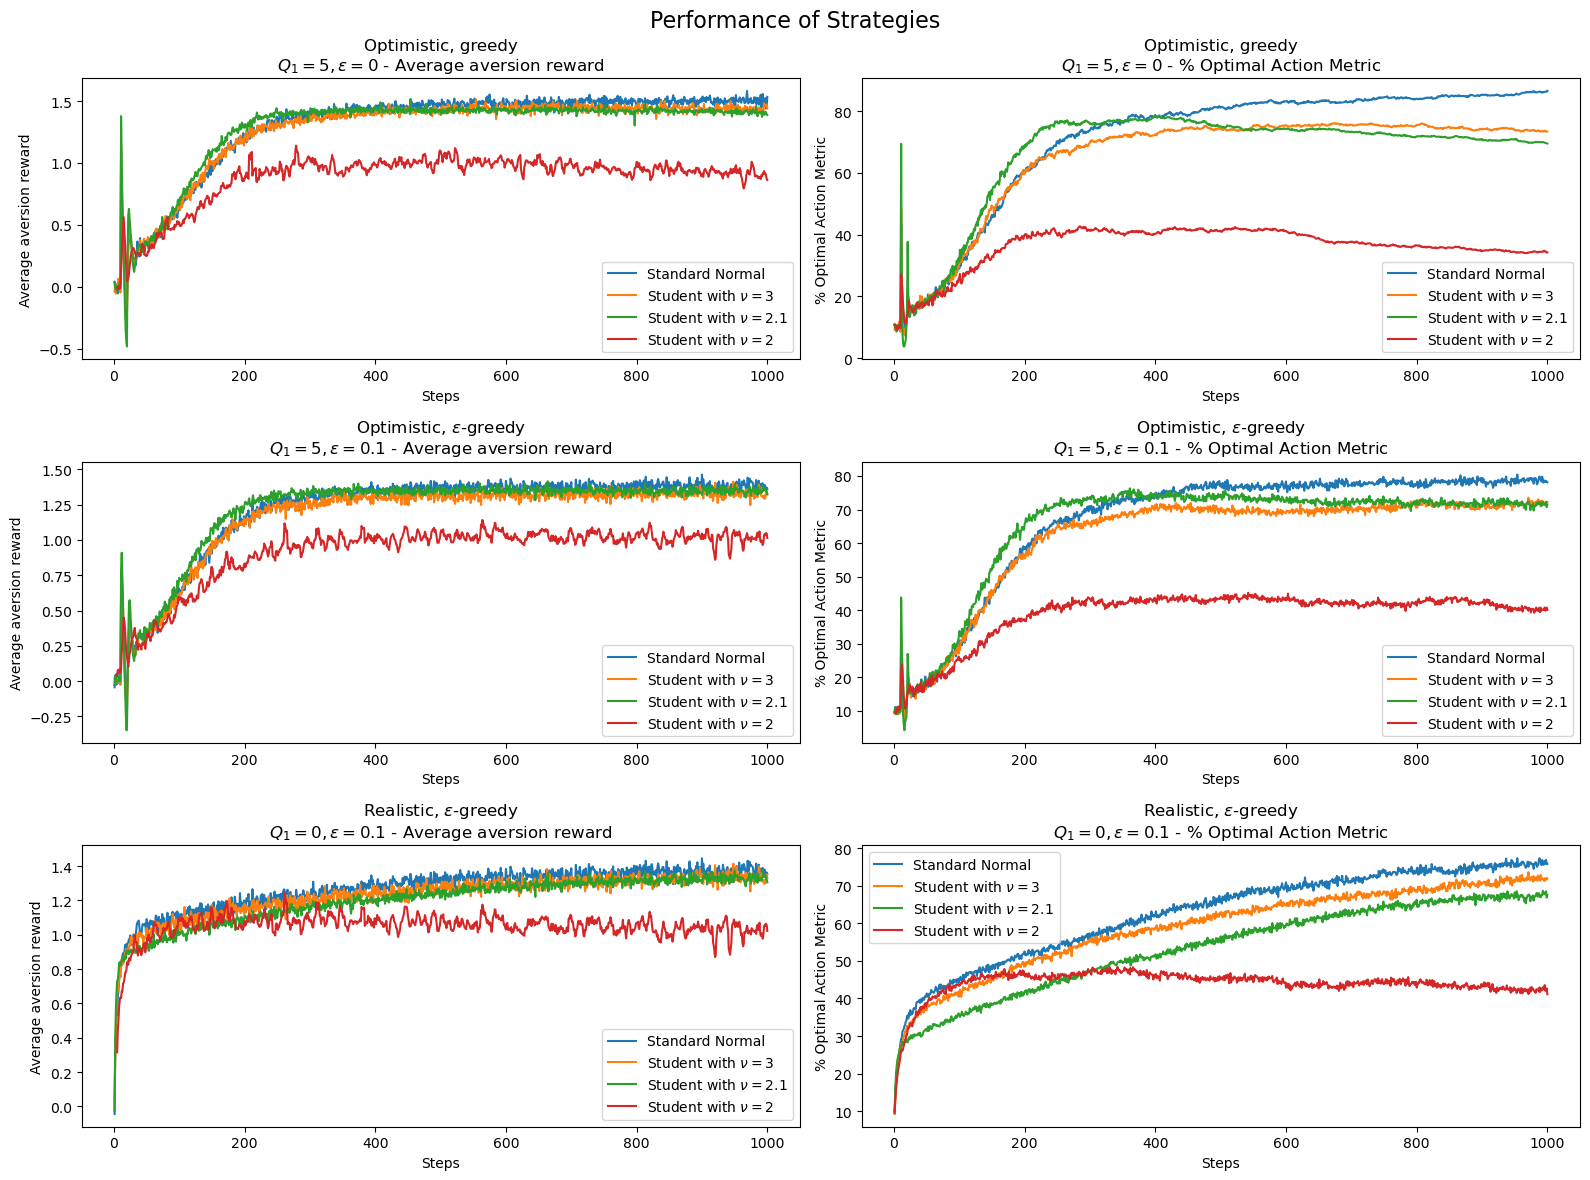

In [143]:
plot_distributions_results(all_metrics['positive_init_test'], labels)

## Upper-Confidence-Bound Action Selection

In [150]:
class UCB(Strategy):
    def __init__(self, num_arms, c=2, step_size=lambda x: 1 / x):
        super().__init__(num_arms, step_size=step_size)
        self.c = c  # Exploration parameter
        self.t = 0 # time

    def choose_arm(self):
        self.t += 1  # Track total number of steps taken
        # Avoid division by zero by adding a small constant to the denominator
        safe_counts = np.maximum(self.counts, 0.001)  # Ensure no element is zero
        upper_bounds = self.q_values + self.c * np.sqrt(np.log(self.t) / safe_counts)
        probs = np.zeros(self.num_arms) / self.num_arms
        probs[np.argmax(upper_bounds)] = 1
        return np.argmax(upper_bounds), probs  # Choose arm with highest upper bound
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.q_values[arm] = self.q_values[arm] + self.step_size(self.counts[arm]) * (reward - self.q_values[arm])

In [151]:
strategies = [UCB, EpsilonGreedy]
strategies_params = [{'c': 2}, {'epsilon': 0.1}]

In [152]:
metrics = compare_strategies(distributions, distributions_params, distributions_names, strategies, strategies_params)

Standard Normal


100%|██████████| 2000/2000 [02:22<00:00, 14.08it/s]


Student with $\nu=3$


100%|██████████| 2000/2000 [02:37<00:00, 12.72it/s]


Student with $\nu=2.1$


100%|██████████| 2000/2000 [02:26<00:00, 13.66it/s]


Student with $\nu=2$


100%|██████████| 2000/2000 [02:20<00:00, 14.19it/s]


Standard Cauchy


100%|██████████| 2000/2000 [02:32<00:00, 13.15it/s]


In [155]:
save_new_metrics(metrics, 'UCB_test')

In [156]:
with open(all_metrics_path,"r") as f:
    all_metrics = json.load(f)

In [23]:
apply_running_window(all_metrics['UCB_test'])

In [25]:
labels = [r"UCB $c=2$", r"$\epsilon$-greedy, $\epsilon = 0.1$"]

def set_ylim(key: str, i: int, axes_flat) -> None:
    # Special adjustments for the last row (Standard Cauchy)
    if key == "Standard Cauchy":
        axes_flat[2 * i].set_ylim(-25, 25)  # Set x-axis limits for average reward
        

def set_label_ylim(key: str, i: int, axes_flat) -> None:
    axes_flat[2 * i].set_ylim(1.2, 1.75)
    axes_flat[2 * i + 1].set_ylim(40, None)

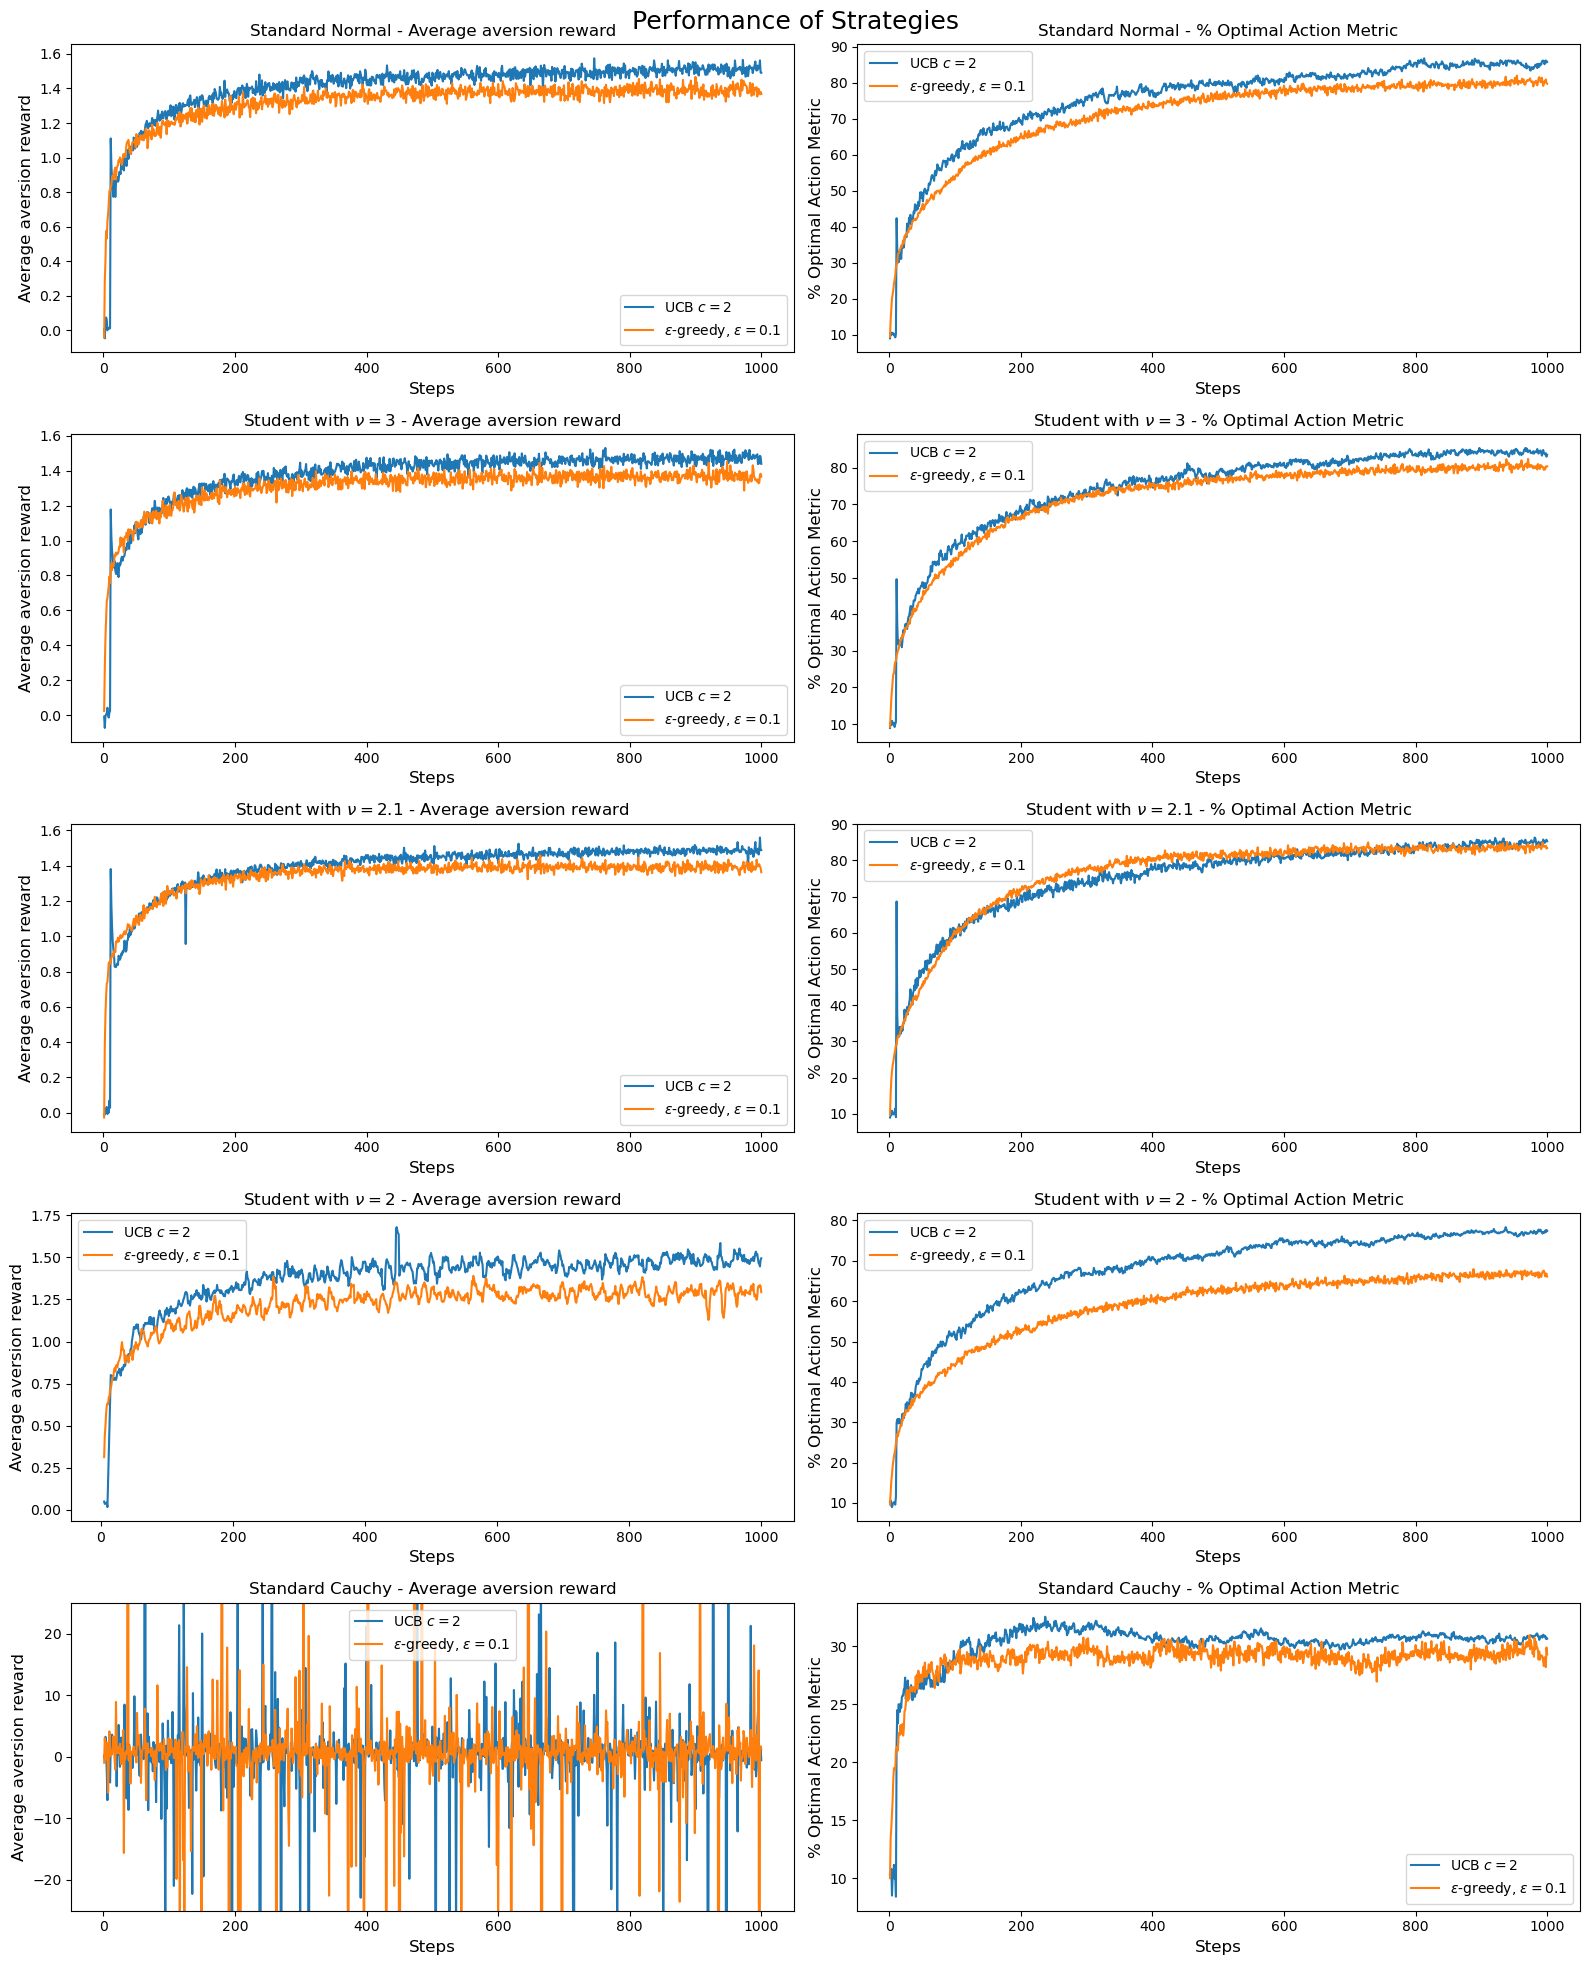

In [159]:
plot_strategies_results(all_metrics['UCB_test'], labels, set_ylim)

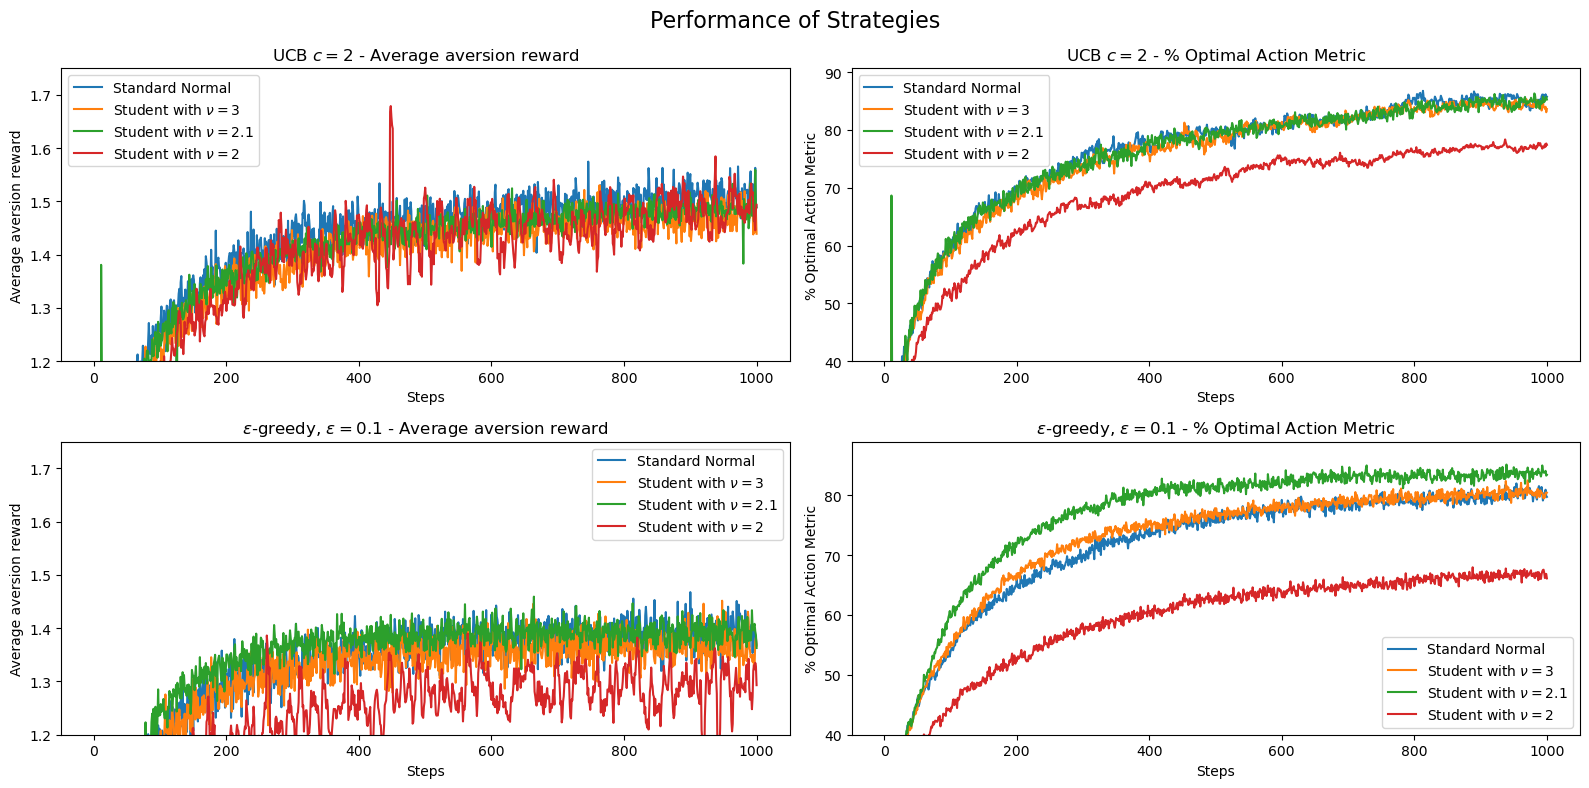

In [26]:
plot_distributions_results(all_metrics['UCB_test'], labels, set_ylim=set_label_ylim)

## Gradient bandits

In [16]:
class GradientBandit(Strategy):
    def __init__(self, num_arms, baseline=True, alpha=0.1, step_size=lambda x: 1 / x):
        super().__init__(num_arms, step_size=step_size)
        self.h_values = np.zeros(self.num_arms)
        self.probs = np.zeros(self.num_arms)
        self.alpha = alpha
        self.has_baseline = baseline
        self.baseline = 0
        self.t = 0

    def choose_arm(self):
        self.probs = np.exp(self.h_values) / np.sum(np.exp(self.h_values))
        return np.random.choice(self.num_arms, p=self.probs), self.probs

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.t += 1

        delta_reward = reward - self.baseline
        self.h_values -= self.alpha * delta_reward * self.probs
        self.h_values[arm] += self.alpha * delta_reward
        self.h_values -= np.max(self.h_values)

        self.baseline += (self.step_size(self.t) * delta_reward) if self.has_baseline else 0


In [14]:
loc_sampler = lambda size: norm.rvs(size=size) + 4
biased_distributions_params = [{'sigma': 1, 'loc_sampler': loc_sampler},
                        {'mu': 3, 'loc_sampler': loc_sampler},
                        {'mu': 2.1, 'loc_sampler': loc_sampler},
                        {'mu': 2, 'loc_sampler': loc_sampler},
                        {'gamma': 1, 'loc_sampler': loc_sampler}]

In [17]:
strategies = [GradientBandit, GradientBandit, GradientBandit, GradientBandit]
strategies_params = [{'baseline': True, 'alpha': 0.1},
                     {'baseline': True, 'alpha': 0.4},
                     {'baseline': False, 'alpha': 0.1},
                     {'baseline': False, 'alpha': 0.4}]

In [178]:
metrics = compare_strategies(distributions, biased_distributions_params, distributions_names, strategies, strategies_params)

Standard Normal


100%|██████████| 2000/2000 [04:13<00:00,  7.89it/s]


Student with $\nu=3$


100%|██████████| 2000/2000 [04:36<00:00,  7.24it/s]


Student with $\nu=2.1$


100%|██████████| 2000/2000 [04:20<00:00,  7.68it/s]


Student with $\nu=2$


100%|██████████| 2000/2000 [04:10<00:00,  7.97it/s]


Standard Cauchy


100%|██████████| 2000/2000 [04:16<00:00,  7.81it/s]


In [179]:
save_new_metrics(metrics, 'gradient_bandits_test')

In [11]:
with open(all_metrics_path,"r") as f:
    all_metrics = json.load(f)

In [181]:
apply_running_window(all_metrics['gradient_bandits_test'])

In [182]:
labels = [r"$\alpha=0.1$, with baseline",
          r"$\alpha=0.4$, with baseline",
          r"$\alpha=0.1$, without baseline",
          r"$\alpha=0.4$, without baseline"]

def set_ylim(key: str, i: int, axes_flat) -> None:
    # Special adjustments for the last row (Standard Cauchy)
    if key == "Standard Cauchy":
        axes_flat[2 * i].set_ylim(-25, 25)  # Set x-axis limits for average reward

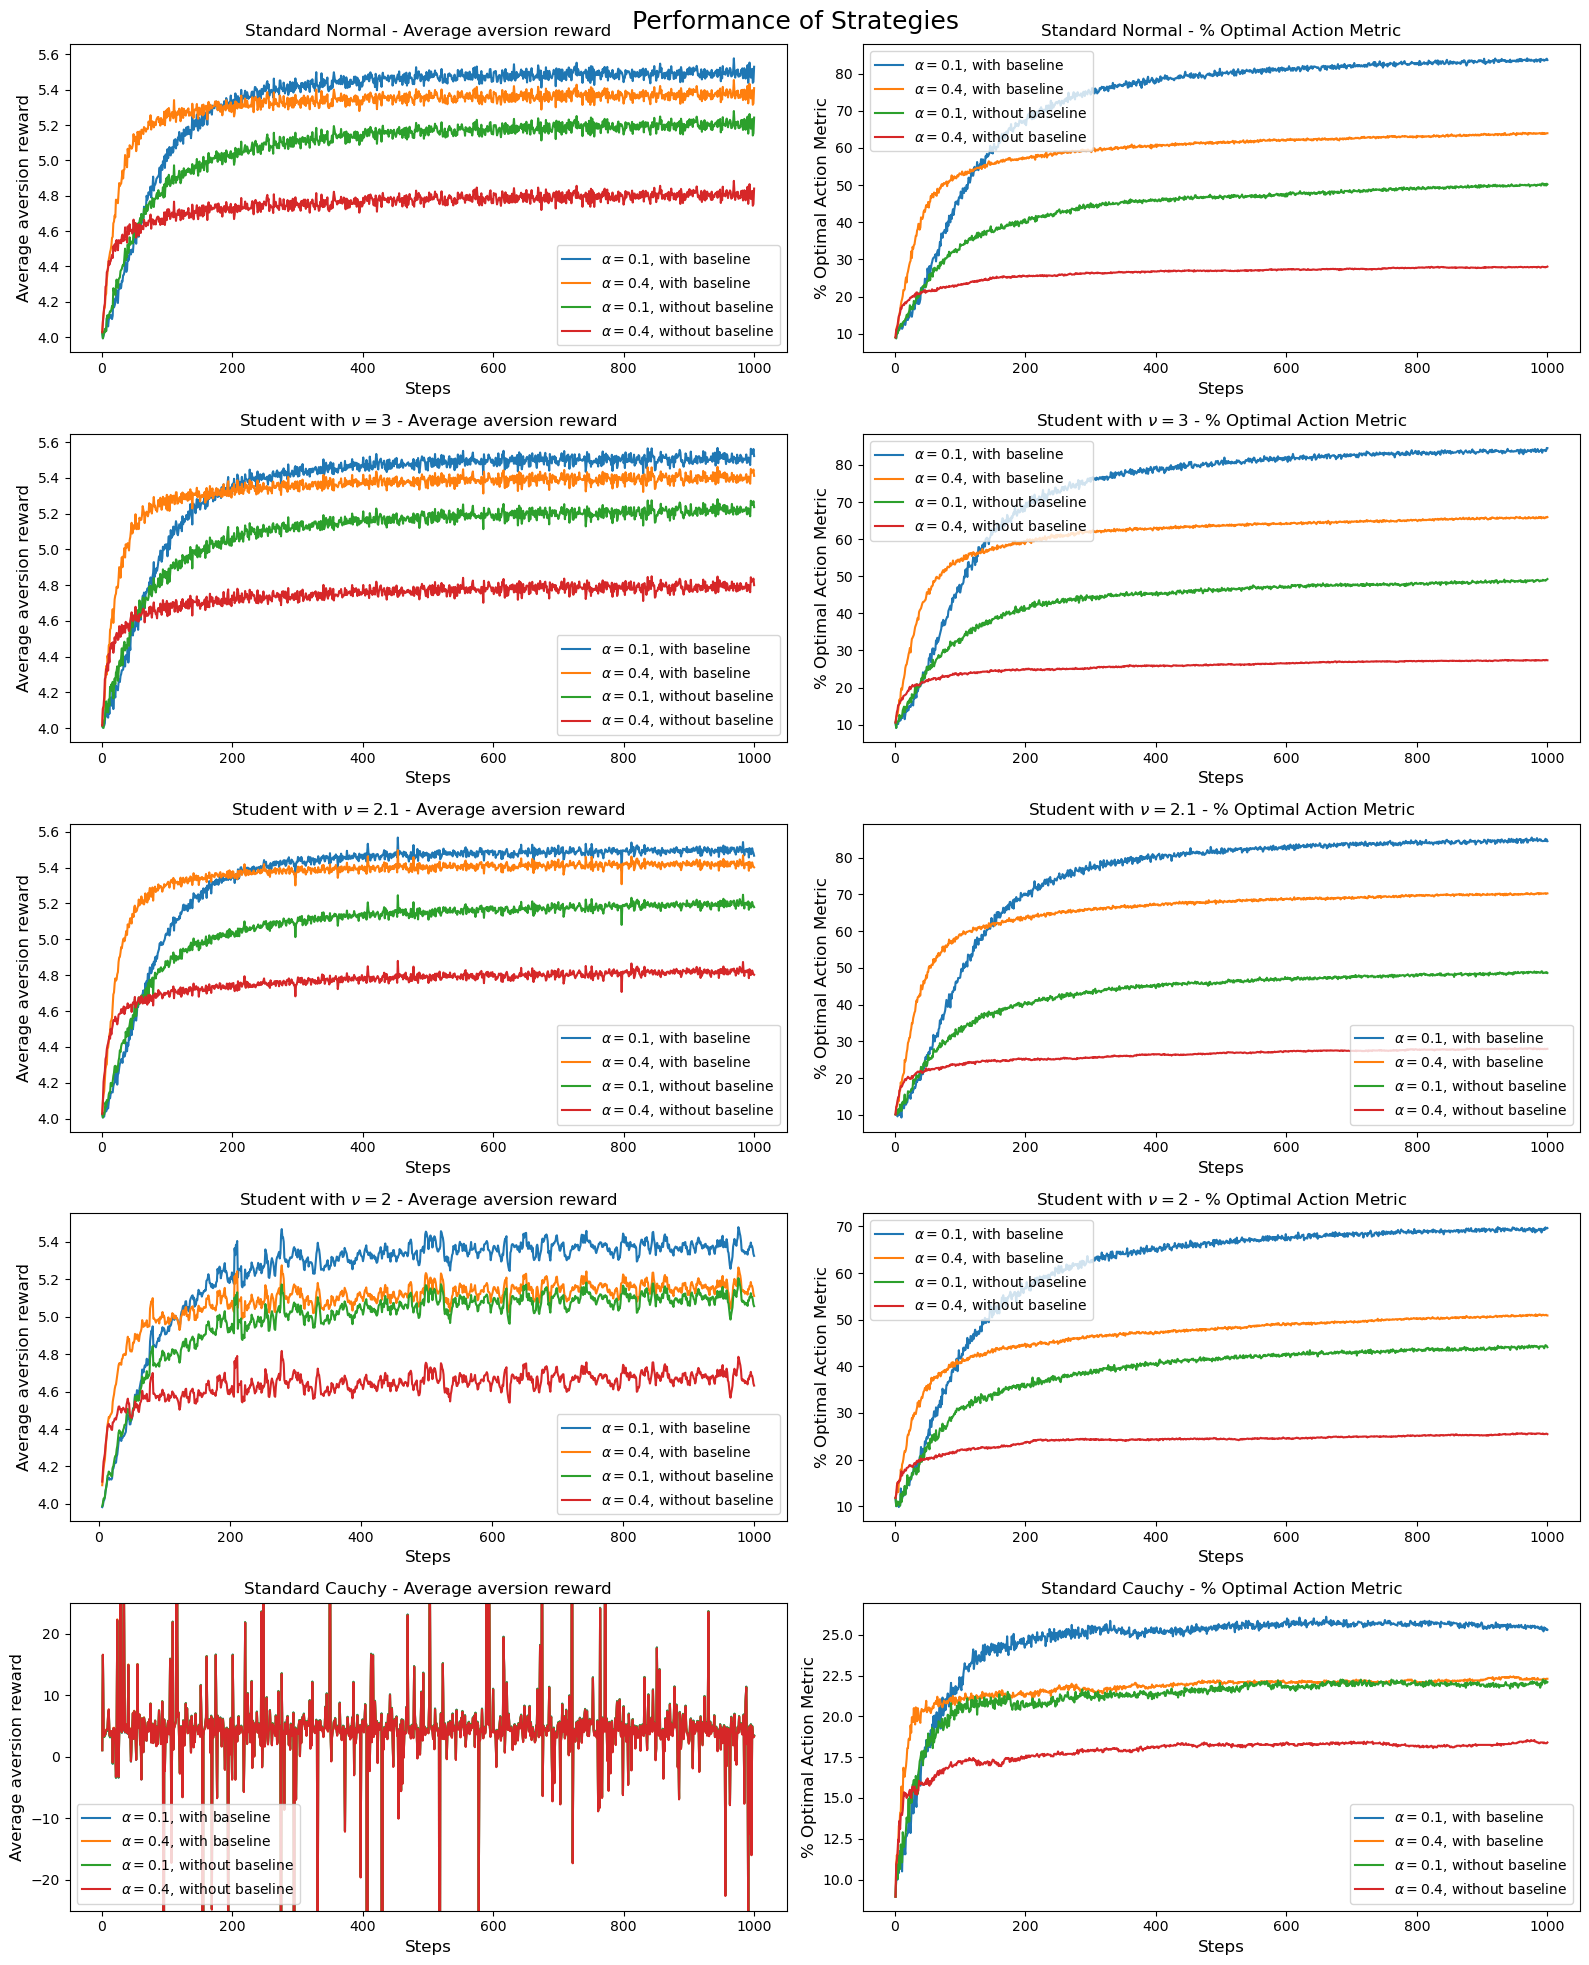

In [183]:
plot_strategies_results(all_metrics['gradient_bandits_test'], labels, set_ylim)

In [18]:
labels = [r"$\alpha=0.1$, with baseline",
          r"$\alpha=0.4$, with baseline",
          r"$\alpha=0.1$, without baseline",
          r"$\alpha=0.4$, without baseline"]

def set_ylim(key: str, i: int, axes_flat) -> None:
    # Special adjustments for the last row (Standard Cauchy)
    if i == 0:
        axes_flat[2 * i].set_ylim(4.8, None)
        axes_flat[2 * i + 1].set_ylim(40, None)
    elif i == 1:
        axes_flat[2 * i].set_ylim(4.6, None)
        axes_flat[2 * i + 1].set_ylim(30, None)
    elif i == 2:
        axes_flat[2 * i].set_ylim(4.6, None)
        axes_flat[2 * i + 1].set_ylim(25, None)
    elif i == 3:
        axes_flat[2 * i].set_ylim(4.3, None)
        axes_flat[2 * i + 1].set_ylim(15, None)

In [20]:
apply_running_window(all_metrics['gradient_bandits_test'])

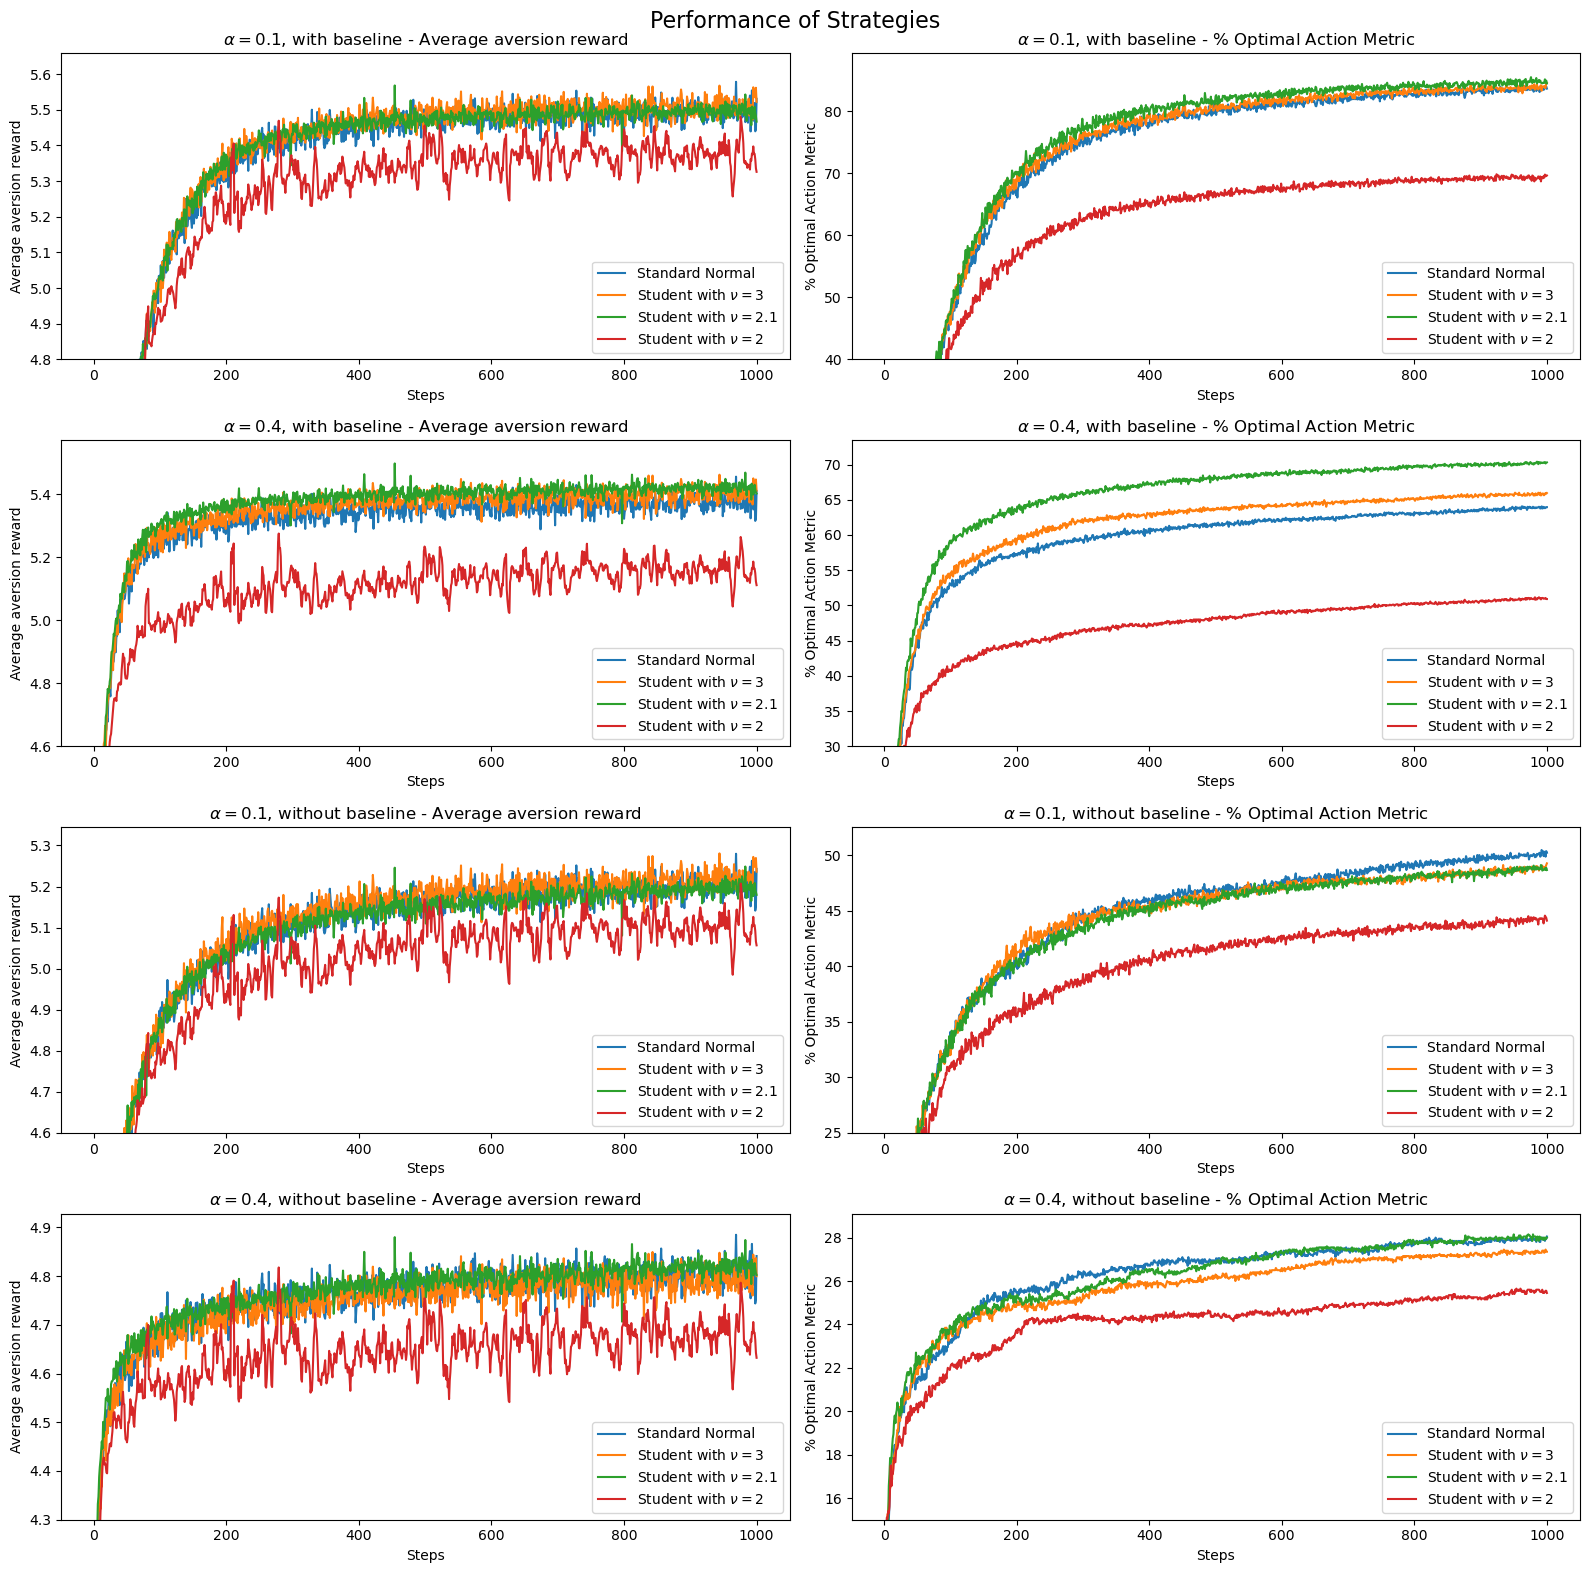

In [21]:
plot_distributions_results(all_metrics['gradient_bandits_test'], labels, set_ylim=set_ylim)

## Overall comparison

In [185]:
strategies = [EpsilonGreedy, PositiveQ, UCB, GradientBandit]
strategies_params = {EpsilonGreedy.__name__: [{'epsilon': 1 / 128}, {'epsilon': 1 / 64}, {'epsilon': 1 / 32}, {'epsilon': 1 / 16}, {'epsilon': 1 / 8}, {'epsilon': 1 / 4}, {'epsilon': 1 / 2}, {'epsilon': 1}, {'epsilon': 2}, {'epsilon': 4}],
                     PositiveQ.__name__: [{'pos_q': 1 / 128}, {'pos_q': 1 / 64}, {'pos_q': 1 / 32}, {'pos_q': 1 / 16}, {'pos_q': 1 / 8}, {'pos_q': 1 / 4}, {'pos_q': 1 / 2}, {'pos_q': 1}, {'pos_q': 2}, {'pos_q': 4}],
                     UCB.__name__: [{'c': 1 / 128}, {'c': 1 / 64}, {'c': 1 / 32}, {'c': 1 / 16}, {'c': 1 / 8}, {'c': 1 / 4}, {'c': 1 / 2}, {'c': 1}, {'c': 2}, {'c': 4}],
                     GradientBandit.__name__: [{'alpha': 1 / 128}, {'alpha': 1 / 64}, {'alpha': 1 / 32}, {'alpha': 1 / 16}, {'alpha': 1 / 8}, {'alpha': 1 / 4}, {'alpha': 1 / 2}, {'alpha': 1}, {'alpha': 2}, {'alpha': 4}]}

In [195]:
def compare_overall(distributions: list[Type[Distribution]],
                    distributions_params: list[dict],
                    distributions_names: list[str],
                    strategies: list[Type[Strategy]],
                    strategies_params: dict[str, list[dict[str, float]]]) -> dict[str, dict[str, dict[str, list[np.double]]]]:

    final_metrics = {}
    final_metrics['average_rewards'] = {}
    final_metrics['optimal_actions'] = {}

    for distribution, distribution_params, distribution_name in zip(distributions, distributions_params, distributions_names):
        print(distribution_name)
        final_metrics['average_rewards'][distribution_name] = {}
        final_metrics['optimal_actions'][distribution_name] = {}

        for strategy in strategies:
            final_metrics['average_rewards'][distribution_name][strategy.__name__] = []
            final_metrics['optimal_actions'][distribution_name][strategy.__name__] = []
            strategy_params = strategies_params[strategy.__name__]
            for one_param in strategy_params:
                if 'epsilon' in one_param.keys() and one_param['epsilon'] >= 1:
                    final_metrics['average_rewards'][distribution_name][strategy.__name__].append(np.nan)
                    final_metrics['optimal_actions'][distribution_name][strategy.__name__].append(np.nan)
                else:
                    bandit_tester = BanditTester(distribution, strategy, distribution_params, strategy_params=one_param, test_num=1000)
                    metrics = bandit_tester.test()
            
                    final_metrics['average_rewards'][distribution_name][strategy.__name__].append(np.mean(metrics['average_rewards']))
                    final_metrics['optimal_actions'][distribution_name][strategy.__name__].append(np.mean(metrics['optimal_actions']))

    return final_metrics

In [196]:
final_metrics = compare_overall(distributions, distributions_params, distributions_names, strategies, strategies_params)

Standard Normal


100%|██████████| 1000/1000 [01:56<00:00,  8.57it/s]


Student with $\nu=3$


100%|██████████| 1000/1000 [02:09<00:00,  7.73it/s]


Student with $\nu=2.1$


100%|██████████| 1000/1000 [02:08<00:00,  7.81it/s]


Student with $\nu=2$


100%|██████████| 1000/1000 [02:06<00:00,  7.93it/s]


Standard Cauchy


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


In [197]:
param_values = {key: [list(val_inner.values())[0] for val_inner in val_outer] for key, val_outer in strategies_params.items()}

In [198]:
x_ticks_labels = ['1 / 128', '1 / 64', '1 / 32', '1 / 16', '1 / 8', '1 / 4', '1 / 2', '1', '2', '4']
x_ticks = [1 / 128, 1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2, 1, 2, 4]

In [202]:
labels = {'EpsilonGreedy': r"$\epsilon$-greedy",
          'PositiveQ': r"greedy with positive init, $\alpha=0.1$",
          'UCB': "UCB",
          'GradientBandit': "gradient bandit"}

In [200]:
save_new_metrics(final_metrics, 'overall_mean_test')

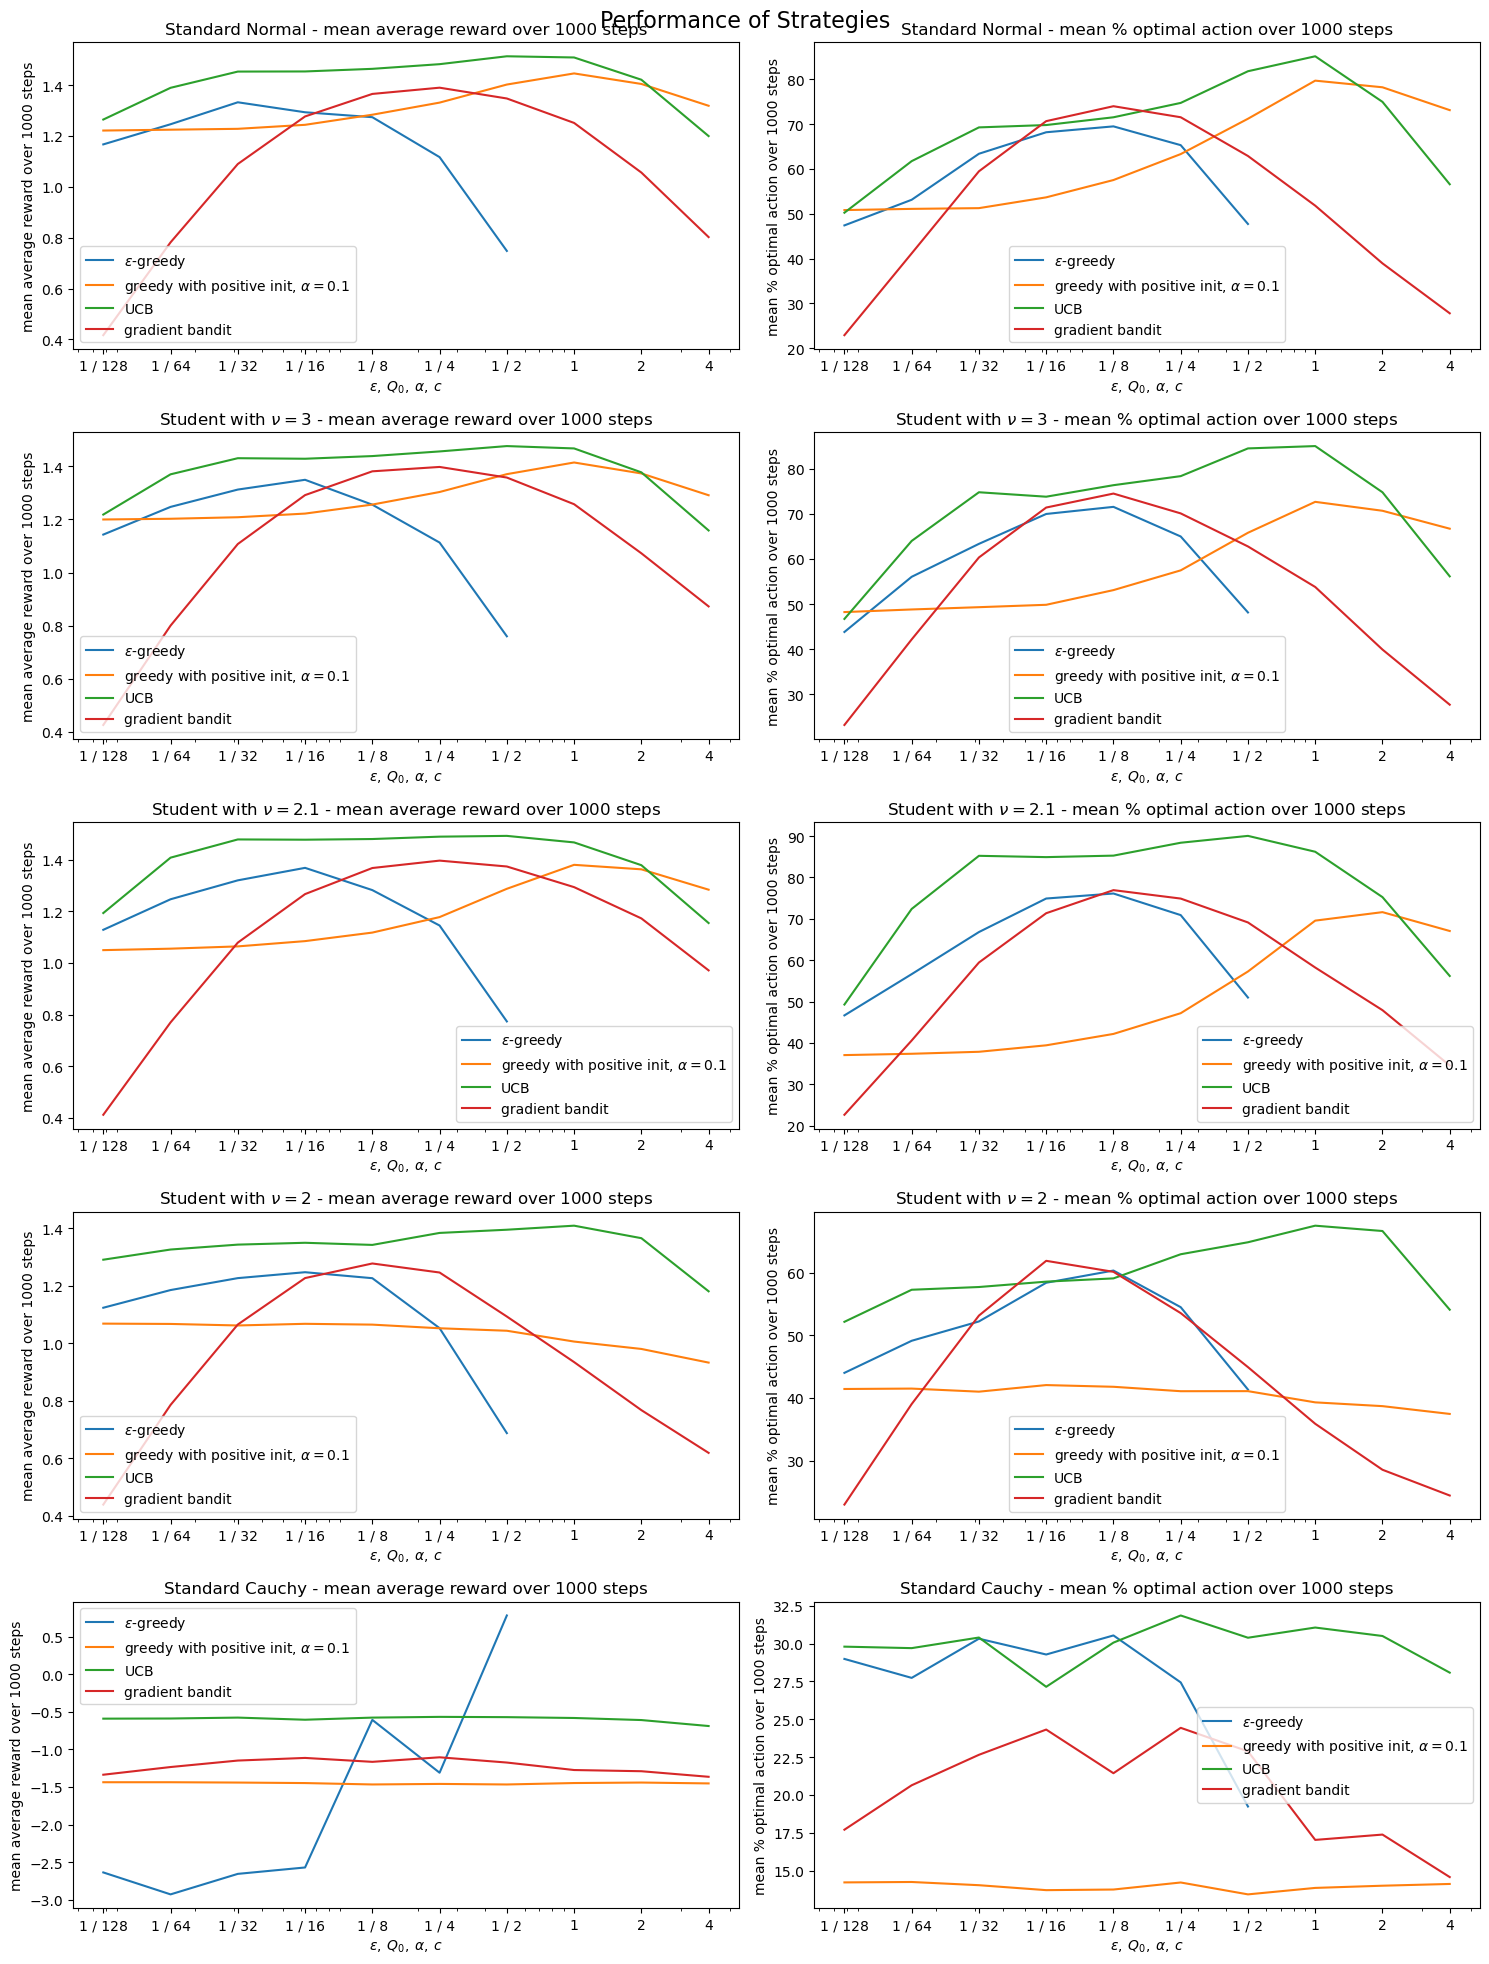

In [203]:
# Define x-axis (steps)

# Create the figure and individual subplots (4 rows, 2 columns)
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Flatten the 2D array of subplots to iterate over them efficiently
axes_flat = axes.flatten()

# Common titles for each plot
fig.suptitle("Performance of Strategies", fontsize=16)
for ax in axes_flat:
    ax.set_xlabel(r"$\epsilon, \: Q_0, \: \alpha, \: c$")

# Loop through each key (distribution)
for i, key in enumerate(final_metrics['average_rewards'].keys()):
    # Set titles for the first column (average reward)
    axes_flat[2 * i].set_title(f"{key} - mean average reward over 1000 steps")
    # Set titles for the second column (optimal action)
    axes_flat[2 * i + 1].set_title(f"{key} - mean % optimal action over 1000 steps")

    # Plot average reward for each epsilon value
    for strategy in labels.keys():
        axes_flat[2 * i].plot(param_values[strategy], final_metrics['average_rewards'][key][strategy], label=labels[strategy])
    axes_flat[2 * i].set_ylabel("mean average reward over 1000 steps")
    axes_flat[2 * i].set_xscale('log')
    axes_flat[2 * i].set_xticks(x_ticks, x_ticks_labels)
    axes_flat[2 * i].legend()

    # Plot optimal actions (convert to percentages) for each epsilon value
    for strategy in labels.keys():
        axes_flat[2 * i + 1].plot(param_values[strategy], [100 * x for x in final_metrics['optimal_actions'][key][strategy]], label=labels[strategy])
    axes_flat[2 * i + 1].set_ylabel(f"mean % optimal action over 1000 steps")
    axes_flat[2 * i + 1].set_xscale('log')
    axes_flat[2 * i + 1].set_xticks(x_ticks, x_ticks_labels)
    axes_flat[2 * i + 1].legend()

    # set_ylim(key, i, axes_flat)
    

# Adjust layout and display the plots
plt.tight_layout()
plt.show()